(0.0, 1.0)

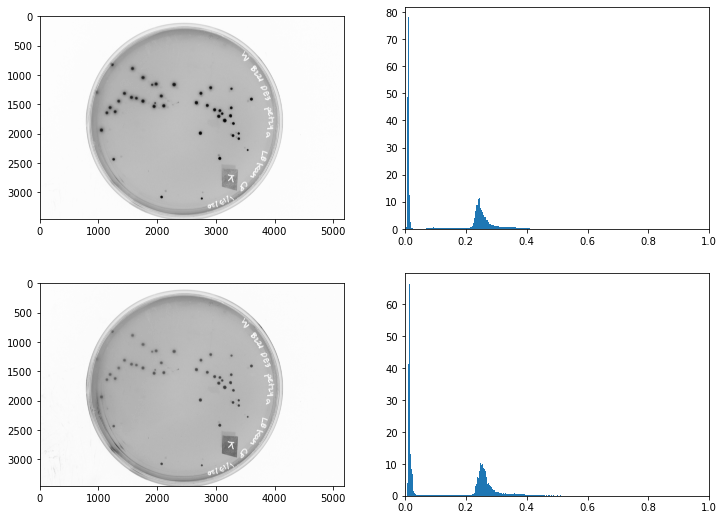

In [1]:
# These images are the work of Carla Perez (http://www.proteindesign.org/people.html)

# We'll use scikit-image, where images are simply NumPy arrays. We already know how to work with NumPy arrays!

from skimage import io as skiio
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

# We'll convert to grayscale as we import
wt_bright = skiio.imread("IMG_0049.JPG", as_gray = True)
wt_dark = skiio.imread("IMG_0050.JPG", as_gray = True)
f, axes = plt.subplots(2, 2, figsize = (12,9))
upperbound = np.max([wt_bright, wt_dark])
axes[0,0].imshow(wt_bright, cmap = 'binary', vmin = 0, vmax = upperbound)
axes[1,0].imshow(wt_dark, cmap = 'binary', vmin = 0, vmax = upperbound)
axes[0,1].hist(wt_bright.flatten(), density = True, bins = 256)
axes[1,1].hist(wt_dark.flatten(), density = True, bins = 256)
axes[0,1].set_xlim(0,1)
axes[1,1].set_xlim(0,1)

0.1393443144914216


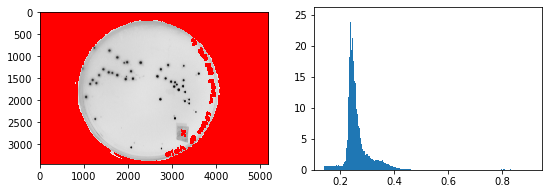

In [2]:
from skimage.filters import threshold_otsu

# Let's remove the background and handwriting. Otsu's method is a procedure for determining an optimal threshold
# by maximizing the sum of the variances 
threshold_wt_bright = threshold_otsu(wt_bright)
print(threshold_wt_bright)
#plt.imshow(wt_bright > threshold_wt_bright, cmap = 'binary')
#plt.colorbar()
wt_bright_masked_background = np.ma.masked_where(wt_bright < threshold_wt_bright, wt_bright)

cmap_badred = plt.get_cmap('binary')
cmap_badred.set_bad('red')

f, axes = plt.subplots(1, 2, figsize = (9,3))
axes[0].imshow(wt_bright_masked_background, cmap = cmap_badred)
_ = axes[1].hist(wt_bright_masked_background.compressed(), bins = 256, density = True)
# Note: matplotlib's hist() does not directly support masked arrays

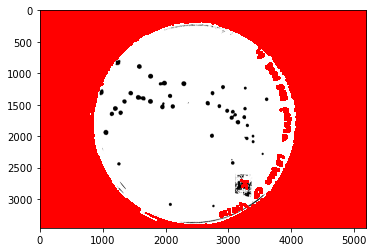

In [3]:
#It is clear from this histogram that the edges of the dish/tape are still a problem after removing the background
plt.imshow(wt_bright_masked_background > 0.4, cmap = 'binary')

# We will have to expand the masked region to exclude these edges
# Let's proceed with the bright image, which should be easier to segment, then use the same final mask on both
# bright and dark images

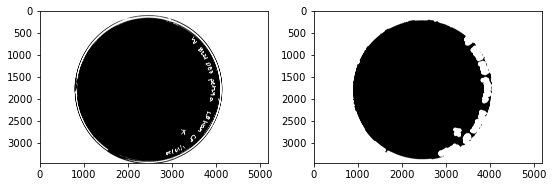

In [4]:
# We'll create a binary array containing the mask, then use binary erosion on it:
from skimage.morphology import erosion
from skimage.morphology import disk

mask_wt_keep = wt_bright > threshold_wt_bright
mask_wt_eroded = erosion(mask_wt_keep, disk(40))

f, axes= plt.subplots(1, 2, figsize = (9,3))
axes[0].imshow(mask_wt_keep, cmap = 'binary')
axes[1].imshow(mask_wt_eroded, cmap = 'binary')

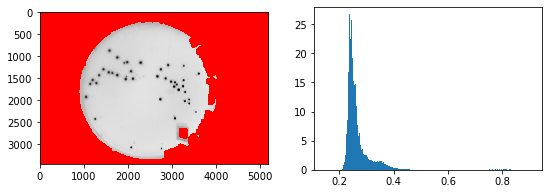

In [5]:
# Now let's re-mask our bright image and histogram:
wt_bright_masked_background = np.ma.masked_where(1 - mask_wt_eroded, wt_bright)

f, axes= plt.subplots(1, 2, figsize = (9,3))
axes[0].imshow(wt_bright_masked_background, cmap = cmap_badred)
_ = axes[1].hist(wt_bright_masked_background.compressed(), bins = 256, density = True)

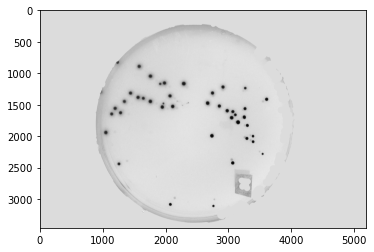

In [6]:
# The easiest way to see how well the edge effects are being removed is by filling the masked pixels with the
# median value, which should be close to the background shade
plt.imshow(np.ma.filled(wt_bright_masked_background, np.ma.median(wt_bright_masked_background)), cmap = 'binary')

In [ ]:
from skimage.feature import blob_log

blobs_log = blob_log(wt_bright_masked_background, min_sigma=1, max_sigma=40, num_sigma=100, threshold=0.15)
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

print(len(blobs_log))

f, axes = plt.subplots(1,2, figsize = (12,6), sharey = True)
axes[0].imshow(wt_bright_masked_background, cmap = cmap_badred)
axes[1].imshow(wt_bright_masked_background, cmap = cmap_badred)
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='blue', linewidth = 1, fill = False, alpha = 0.3)
    axes[1].add_patch(c)

f.savefig("~/fmntest.pdf")